## Novoic ML Challenge (Image)
By Joshua Placidi

### Imports

In [1]:
from tqdm.notebook import tqdm
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import altair as alt
import os

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

from pylab import rcParams
rcParams['figure.figsize'] = 25, 50

cats =  ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

### Processing Data

In [2]:
process_data = False

if(process_data):
    df = pd.DataFrame(columns=(cats))

# This for loop creates a new row in the df dataframe for each image with default column values of 's'. 's' is used to identify cells that do not get overwritten when copying in category labels.
# This is commented out due to a large number of images not containing accompaning labels
#
#     for image_path in tqdm(os.listdir("./data/images")):
#         df.loc[image_path[:-4]] = ['s']*20


    # Copy values from individual text files into a single dataframe
    for cat in cats:
        file = open('data/' + cat + '.txt', "r")
        line_counter = 0
        for line in file:
            values = line.split()
            df.at[values[0],cat] = values[1]
            line_counter += 1
        file.close()

    # Format dataframe and save it
    df = df.reset_index()
    df.columns.values[0] = 'image'
    df.to_csv('df.csv', index=False)
    df.info()
else:
    df = pd.read_csv('df.csv')

After analysing the data it appears that only 11,540 images of the 17,500 provided have accompaning labels. To ensure accuracy, only the images with labels will be used to train and evualate the model.

### Visualising data distribution

Creating a bar chart to show the frequency of each category in the image labels

Dark purple represents a clearly featured object (1), light purple represents a difficult to recognise object (0)

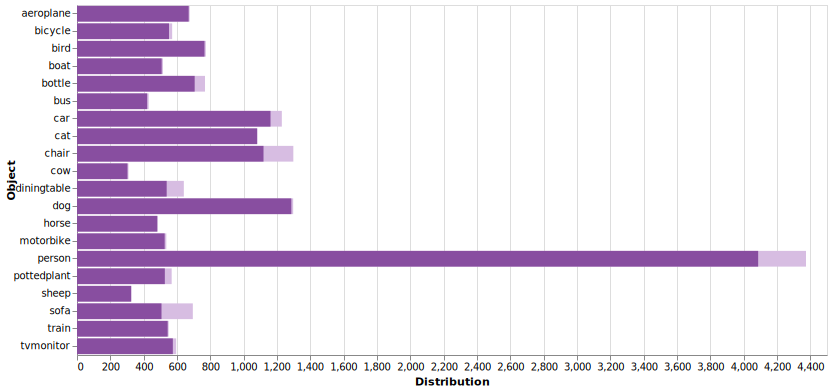

In [26]:
bar_chart_data = pd.DataFrame({'category': cats})

# Create bar_chart_data
for i in range(len(cats)):
    bar_chart_data.at[i,'0'] = df.groupby(cats[i]).size()[0] + df.groupby(cats[i]).size()[1]
    bar_chart_data.at[i,'1'] = df.groupby(cats[i]).size()[1]

# Declaring bar charts
bar_chart_height, bar_chart_width = 350, 750

# Images with category label of '0'
object_0 = alt.Chart(bar_chart_data).mark_bar().encode(
    x=alt.X('0', title='Distribution'),
    y=alt.Y('category', title='Object'),
    color=alt.value('#D7BDE2')
).properties(
    width= bar_chart_width,
    height= bar_chart_height
)

# Images with category label of '1'
object_1 = alt.Chart(bar_chart_data).mark_bar().encode(
    x=alt.X('1', title='Distribution'),
    y=alt.Y('category', title='Object'),
    color=alt.value('#884EA0')
).properties(
    width= bar_chart_width,
    height= bar_chart_height
)

# Print both charts together
object_0 + object_1

# GitHub doesnt support showing altair charts online, I have attached a SVG image of the graph:
from IPython.display import SVG, display
display(SVG(url='https://raw.githubusercontent.com/JoshuaPlacidi/Novoic-Image-Challenge/main/standard_distribution.svg?token=AP7UCHF27HU3OAF3Q2BD3IK7UQWBM'))

The distributrion shows that the 'person' category is much more populus then all others. This suggests that the dataset is imbalanced and considerations will need to be made to avoid creating a classifier which simply predicts the 'person' category for every input.

### Distribution given another categories presence

Visualising the distribution of all other categories a specified category is present in an image. P(X|Y) where Y is the specified category and X is the set of all other categories.

In [4]:
# Declare new dataframe to store new distribution
pxy = pd.DataFrame()
df = pd.read_csv('df.csv')
for cat1 in cats:
    # Filter dataset to only images that cat1 in present in
    cat1_df = df[df[cat1] == 1]
    for cat2 in cats:
        temp = cat1_df.groupby(cat2).size().reset_index()
        
        # If cat2 shares images with cat1 calculate the number of shared images divided by the number of cat1 images (% of shared images)
        # If statements checking if a subset dataframe is not empty and if so tally its instances
        if((temp.loc[temp[cat2] == 1].empty == False) and (temp.loc[temp[cat2] == 0].empty == False)):
            pxy.at[cat1,cat2] = (temp.loc[temp[cat2] == 1].iloc[0][0] + temp.loc[temp[cat2] == 0].iloc[0][0]) * 100 / cat1_df.shape[0]
        elif(temp.loc[temp[cat2] == 0].empty == False): 
            pxy.at[cat1,cat2] = (temp.loc[temp[cat2] == 0].iloc[0][0]) * 100 / cat1_df.shape[0]
        elif(temp.loc[temp[cat2] == 1].empty == False): 
            pxy.at[cat1,cat2] = (temp.loc[temp[cat2] == 1].iloc[0][0]) * 100 / cat1_df.shape[0]

# Format new dataframe
pxy = pxy.reindex(sorted(pxy.columns), axis=1).fillna(0).round(2)

In [5]:
# Return a chart showing the P(X|Y) distribution
#
# cat: category to show distribtion for (Y variable)
#
def pxy_chart(cat):
    # Filter and format chart data
    pxy_chart_data = pxy
    np.fill_diagonal(pxy_chart_data.values, 0)
    pxy_chart_data = pxy_chart_data.T.reset_index()
    pxy_chart_data = pxy_chart_data[pxy_chart_data['index'] != cat]
    
    # Define bar chart
    bars = alt.Chart(pxy_chart_data, title=cat).mark_bar().encode(
      x=alt.X(cat, title='Instances'),
      y=alt.Y('index', title='Categories'),
      color=alt.value('#884EA0')
    )
    
    # Define text labels
    text = bars.mark_text(
      align='left',
      baseline='middle',
      dx=3
    ).encode(
      text='label:N'
    ).transform_calculate(label='datum.' + cat + ' + "%"')

    return (bars + text).properties(
      width= bar_chart_width,
      height= bar_chart_height
    )

Probabilty distribution of other categories featuring in an image given that a person appears in it


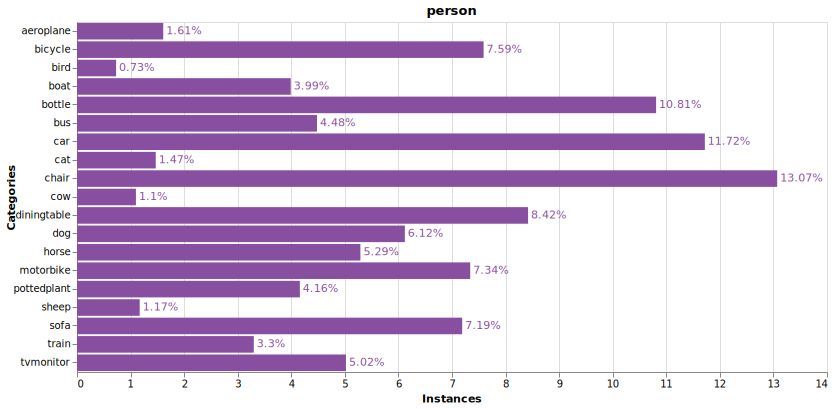

In [29]:
import random
# Select a category from cats and show its distribution graph
selected_cat = 'person' # random.choice(cats)
print('Probabilty distribution of other categories featuring in an image given that a ' + selected_cat + ' appears in it')
pxy_chart(selected_cat)

# GitHub doesnt support showing altair charts online, I have attached a SVG image of the graph:
display(SVG(url='https://raw.githubusercontent.com/JoshuaPlacidi/Novoic-Image-Challenge/main/cats_given_cat_distribution.svg?token=AP7UCHEXBTVXQCUNSZC2PZ27UQWSU'))

### Multi-Label Image Classifier

Designing a classifier to attempt to predict probabilty that categories feature in an input image

In [7]:
# Run on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
# Declaring a custom dataset class for formatting images and labels and applying transformsations
class ImageDataset(Dataset):
    # Reading data from csv and formatting correctly, declaring transformations
    def __init__(self, csv, root_dir):
        self.image_paths = np.asarray(csv.reset_index()['image'])
        self.labels = np.asarray(csv.iloc[:,0:])
        self.root_dir = root_dir
        self.resize = transforms.Resize((185,185))
        self.ran_hor_flip = transforms.RandomHorizontalFlip()
        self.ran_crop = transforms.RandomCrop(150)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)
    
    # Called when an instance is requested, return label and transformed image
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root_dir, self.image_paths[idx] + '.jpg'))
        image = self.resize(image)
        image = self.ran_hor_flip(image)
        image = self.ran_crop(image)
        image = self.to_tensor(image)
        labels = self.labels[idx]
        return image, labels

In [9]:
# Function to normalise label data range from -1, 0, 1 to 0, 0.5, 1
# x: value to normalise
def norm(x):
    return (x+1)/2

df = pd.read_csv('df.csv').set_index('image')
form_csv = df.apply(pd.to_numeric)
form_csv = form_csv.apply(norm)

# Experimenting with removing the person category to see the effect on the trained model
#del form_csv['person']


# Create dataset
dataset = ImageDataset(csv=form_csv, root_dir ='./data/images')

# Declaring dataloader parameters
batch_size = 16
validation_split = .1
shuffle_dataset = True
random_seed = 42

# Shuffle data and split into training and validation set (90% train, 10% val) for true evaluation -> (80% train, 10% val, 10% test)
indices = list(range(len(dataset)))
split = int(np.floor(validation_split * len(dataset)))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Define dataloaders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

form_csv.head(5)

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
image,,,,,,,,,,,,,,,,,,,,
2008_000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2008_000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2008_000007,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008_000008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2008_000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


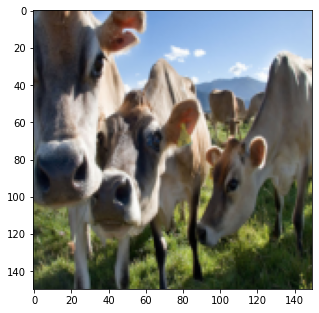

Ground truths: cow 

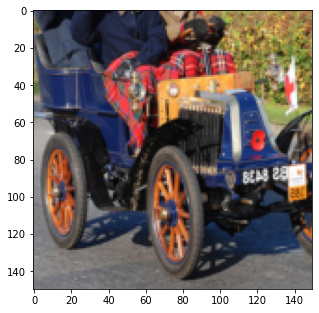

Ground truths: car person 

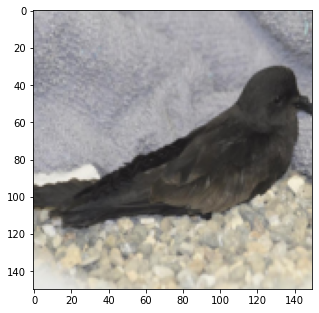

Ground truths: bird 

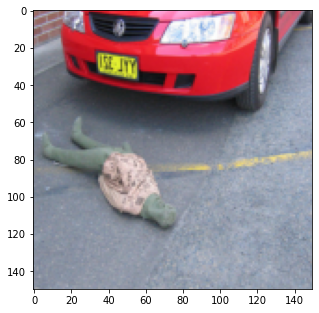

Ground truths: car 

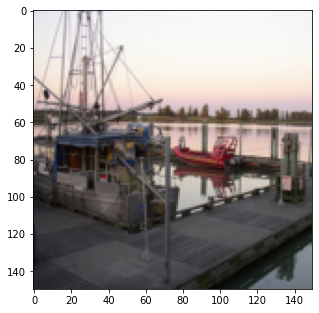

Ground truths: boat 

In [10]:
# Visualise random ground truths from the train set

rcParams['figure.figsize'] = 5, 10

train_iter = iter(train_loader)
images, labels = train_iter.next()

for instance in range(batch_size):
    
    image, label = images[instance], labels[instance]
    npimg = image.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    ground_truths = np.where(label.cpu().numpy() != 0)[0]
    print('Ground truths: ', end='')
    for cat_index in ground_truths:
        print(cats[cat_index], end=' ')
        
    if instance == 4: break

### Define classifier
Define CNN model

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Defining net layers
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.fc1 = nn.Linear(64*75*75, 1024)
        self.fc2 = nn.Linear(1024, 255)
        self.fc3 = nn.Linear(255, 84)
        self.fc4 = nn.Linear(84, 20)

    def forward(self, x):
        # Applying forward pass
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(self.pool(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.bn2(self.conv3(x)))
        # Shape (16,64,75,75)
        x = x.view(-1, 64*75*75)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=360000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=255, bias=True)
  (fc3): Linear(in_features=255, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=20, bias=True)
)

In [12]:
# Defining criterion and optimizer to be used in training
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [13]:
epochs = 9
print_loss_every = 250

# Training loop
for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        # Get images and labels and move them to GPU
        images, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels.type_as(outputs))
        loss.backward()
        optimizer.step() 

        # calculate loss
        running_loss += loss.item()         
        # Print loss every 250 cycles
        if i % print_loss_every == (print_loss_every-1):
            print('[%d,%5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / print_loss_every))
            running_loss = 0.0
            
print('Finished Training')

[1,  250] loss: 0.359
[1,  500] loss: 0.230
[2,  250] loss: 0.221
[2,  500] loss: 0.217
[3,  250] loss: 0.212
[3,  500] loss: 0.209
[4,  250] loss: 0.208
[4,  500] loss: 0.203
[5,  250] loss: 0.201
[5,  500] loss: 0.199
[6,  250] loss: 0.194
[6,  500] loss: 0.196
[7,  250] loss: 0.195
[7,  500] loss: 0.195
[8,  250] loss: 0.188
[8,  500] loss: 0.191
[9,  250] loss: 0.188
[9,  500] loss: 0.189

Finished Training


In [14]:
# Save/Load trained models

# PATH = './trained_model.pth'
# torch.save(net.state_dict(), PATH)

In [15]:
# net = Net()
# net.load_state_dict(torch.load(PATH))

### Evaluating model performance

In [24]:
import math

sum_error = 0
total = 0

# Calculate total euclidean vector distance in a batch
#
# x = predictions
# y = ground truth labels
#
def cal_error(x,y):
    current_error = 0
    error = 0
    for i in range(len(x)):
        a = x[i]
        b = y[i]
        for j in range(len(a)):
            current_error += (a[j] - b[j])**2
    error += math.sqrt(current_error)
    return error

# Loop through all validation data and calculate the mean error (euclidean distance)
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        prob = F.softmax(outputs, dim=1)
        total += 1
        sum_error += cal_error(prob,labels)

print('Mean euclidean vector distance on ' + str(total) + ' validation batches (' + str(total * batch_size) + ' images): ' + str(round((sum_error / total),3)))

Mean euclidean vector distance on 73 validation batches (1168 images): 4.109


Mean euclidean distance between ground truth vector and predicted vector is 4.092, giving a average category error of 4.109/20 = 0.205

#### Visualising predictions

Visualising model predictions on batches in the validation set. Predictions are set up so that for each image the 3 most certain categories from the output tensor will be printed next to the ground truths of the image.



We can see that the model performs decently well at selecting at least on correct classification per image, however a general bias towards the person category can be noticed. To further improve on the models performance I would suggest using transfer learning with a deeper model pre-trained on a much larger image dataset (CIFAR-10, ImageNet ect) ideally one that supports multi-label classification.

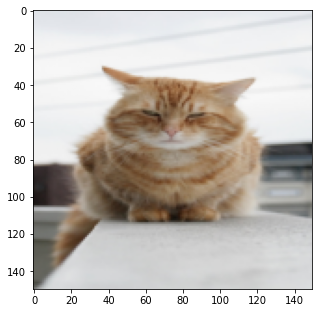

Ground truths: cat 

cat (0.57%)  dog (0.29%)  person (0.06%)  



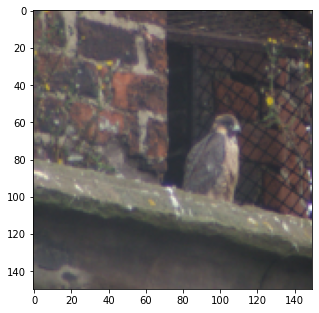

Ground truths: bird 

person (0.29%)  dog (0.22%)  cat (0.17%)  



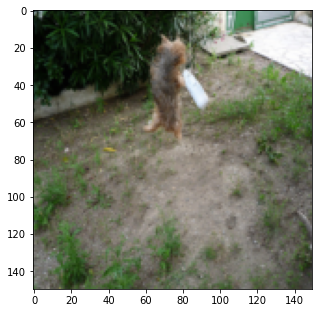

Ground truths: bottle dog 

dog (0.36%)  sheep (0.3%)  cow (0.1%)  



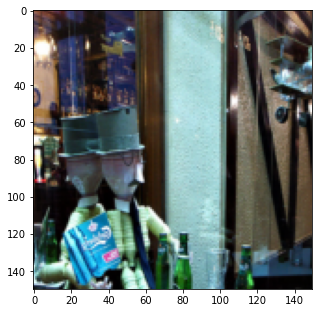

Ground truths: bottle 

person (0.28%)  dog (0.16%)  cat (0.1%)  



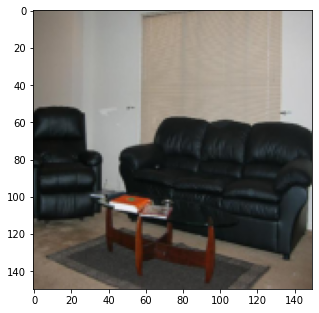

Ground truths: chair sofa 

chair (0.28%)  pottedplant (0.14%)  person (0.11%)  



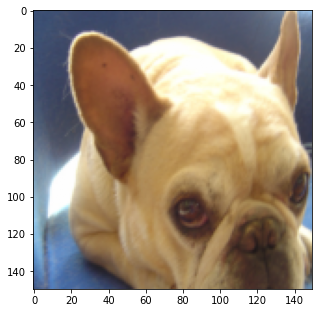

Ground truths: dog 

dog (0.23%)  person (0.22%)  cat (0.17%)  



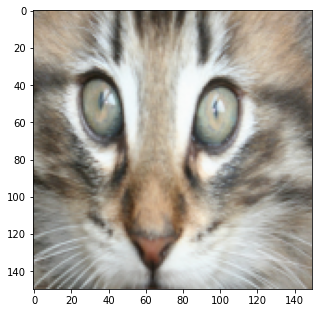

Ground truths: cat 

cat (0.51%)  dog (0.41%)  sheep (0.02%)  



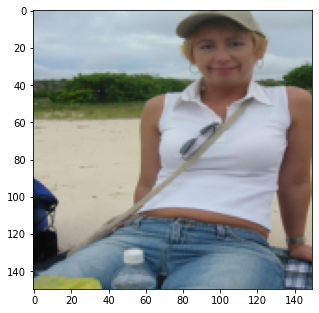

Ground truths: bottle person 

person (0.56%)  chair (0.09%)  bottle (0.07%)  



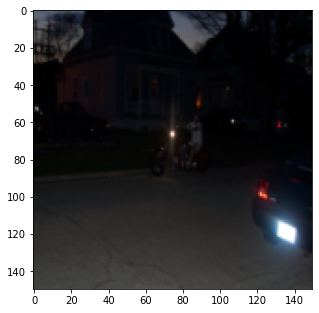

Ground truths: car motorbike person 

cat (0.33%)  person (0.22%)  dog (0.15%)  



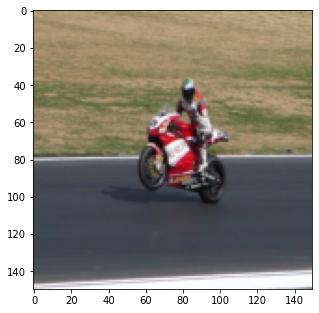

Ground truths: motorbike person 

person (0.45%)  motorbike (0.34%)  car (0.04%)  



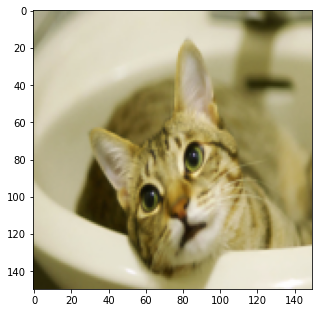

Ground truths: cat 

bird (0.28%)  dog (0.22%)  cat (0.16%)  



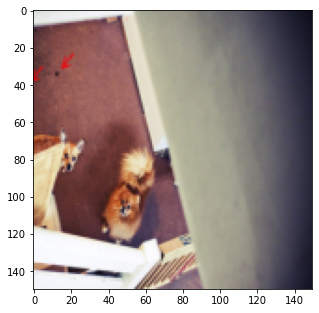

Ground truths: dog 

person (0.44%)  cat (0.13%)  dog (0.12%)  



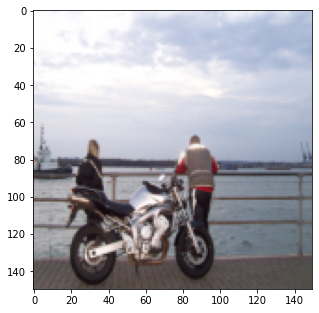

Ground truths: boat motorbike person 

motorbike (0.39%)  person (0.29%)  car (0.19%)  



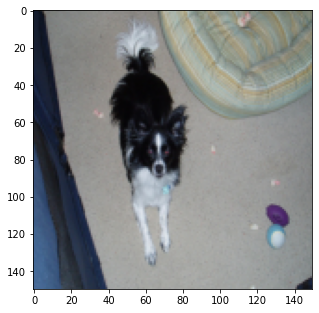

Ground truths: dog 

person (0.33%)  dog (0.26%)  cat (0.21%)  



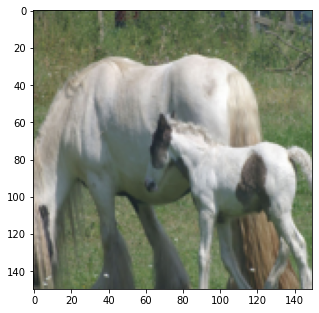

Ground truths: horse 

sheep (0.2%)  dog (0.2%)  horse (0.16%)  



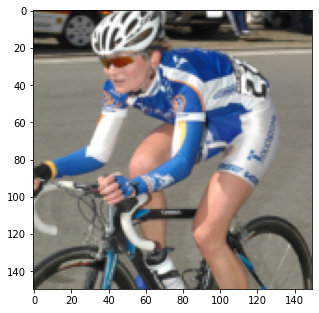

Ground truths: bicycle bottle car person 

motorbike (0.46%)  person (0.38%)  bicycle (0.08%)  



In [20]:
rcParams['figure.figsize'] = 5, 10

# Visualise validation images with ground truths and predictions
val_iter = iter(val_loader)
data_batch = val_iter.next()
images, labels = data_batch[0].to(device), data_batch[1].to(device)

# Get predictions and calculate high predicted classes
outputs = net(images)
prob = F.softmax(outputs, dim=1)
num_top_classes = 3
top_p, top_class = prob.topk(num_top_classes, dim = 1)

# Loop through batch printing images with groud truths and predictions
for instance in range(batch_size):
    image, label = images[instance], labels[instance]
    npimg = image.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    ground_truths = np.where(label.cpu().numpy() != 0)[0]
    print('Ground truths: ', end='')
    
    for cat_index in ground_truths:
        print(cats[cat_index], end=' ')
    print('\n')
    
    for i in range(num_top_classes):
        print(cats[top_class[instance][i]], '(' + str(round(top_p[instance][i].item(), 2)) + '%)  ',end='')
    print('\n')